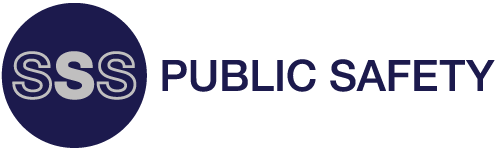


## PoliceWorks            
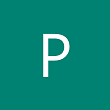 

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## KT Session on the PoliceWorks data

> <div class="alert alert-block alert-info">designed to recreate the database KT sessions given by Matthew, Chris and others  </div>

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### Establish the connection

In [ ]:
#engine = setup_connection('V-PW-DEVDB08.lab.stl.local\CRM2016;')
import nbimporter
from data_access import db_access as db

from data_access.db_access import get_single_value
from data_access.db_access import display_data

db.setup_connection('V-PW-DEV08-DB01.lab.stl.local\PWDEV08')

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Databases
> List all the databases, only some of the more important ones will be considered in this session

In [2]:
q = "SELECT [name] FROM [sys].[databases] where database_id > 4;"
display_data(q)

,name
0,ReportServer$PWDEV08
1,ReportServer$PWDEV08TempDB
2,MSCRM_CONFIG
3,POLCASE_MSCRM
4,PWCCDayOneData
5,POLCASE_GeneralSqlCacheDb
6,POLCASE_DocStorageDb
7,POLCASE_ReportWorksCacheDb
8,POLCASE_SignalRBusDb
9,POLCASE_DataQueryDB


### POLCASE_CONFIG

Look at some tables in POLCASE_CONFIG - for configuration and end point data. This could be useful for setting up a machine but mostly won't be needed for a while.

In [ ]:
q = "SELECT TOP 10 * FROM [POLCASE_CONFIG].[dbo].[ApplicationConfig]  WITH(NOLOCK);"
display_data(q)

In [ ]:
q = "SELECT TOP 100 * FROM [POLCASE_CONFIG].[dbo].EndPoints  WITH(NOLOCK);"
display_data(q)

### POLCASE_DMSBeats

> is used by the BizTalk interface. It gives officer availability, though limited data in test databases

In [ ]:
q = "SELECT TOP 100 * FROM [POLCASE_DMSBeats].[dbo].[DutyPlans]  WITH(NOLOCK);"
display_data(q)

### POLCASE_DocStorageDb

> for all the documents produced by the system - it points to their location on disk.
It is important to remember that there is an UnstructuredDataId

In [ ]:
q = "SELECT TOP (10) * FROM [POLCASE_DocStorageDb].[dbo].[STL_UnstructuredData]  WITH(NOLOCK);"
display_data(q)

### POLCASE_GeneralSQLCacheDb

> used for cacheing to speed up our service layer.

### InterfaceDataQueryDb

> used for the PND interface (this db is not found on some test servers). The PND extract tool in the V2 world is known as generic data extract.

Just be aware these exist.

### POLCASE_Logging
>is the audit database for our RMS service layer.

It has a single table that stores all the requests that were made. Used more for debugging purposes e.g. to triage events in GMP.
You will see a lot more of this when you have security clearance.
Holds the past three days worth of data. Only for GMP, Cumbria and Durhamdo not have RMS

In [ ]:
q = "SELECT TOP (10) * FROM [POLCASE_Logging].[dbo].[CallLog]  WITH(NOLOCK);"
display_data(q)

### POLCASE_DataQueryDb

> Has an audit table that shows what views were called and the sql used. 

This can be useful for debugging
It's a bit tricky to extract the sql from the text returned. I spent some time trying to work out how to display the formatted xml but failed.
The failure to install below may be a blocker for this:


!py -m pip install lxml
This failed with the message Microsoft Visual C++ 14.0 or greater is required - but then trying to install that failed because of my .net issues!

In [ ]:

q = "SELECT TOP (1) [diagnosticinfo] FROM [POLCASE_DataQueryDB].[DataQuery].ExecutionHistory  WITH(NOLOCK);"
print(get_single_value(q))


Other tables in POLCASE_DataQueryDb are used by the documents. 
ViewDefinition will populate a dropdown when you "Select Schema" for a document and this will link to a view

In [ ]:
q = "SELECT TOP 10 * FROM [POLCASE_DataQueryDB].[DataQuery].[ViewDefinition]  WITH(NOLOCK);"
display_data(q)


ViewComponent and ViewComponentCollection contain some configuration information (don't fully understand). It seems that they define parameters that are sent through from the screen you are in - e.g. if you request the doc from a case file then the id of the case file will be sent through.

In [ ]:
q = "SELECT TOP 10 * FROM [POLCASE_DataQueryDB].[DataQuery].[ViewComponent]  WITH(NOLOCK);"
display_data(q)


There are mainly a large number of views (734) in this database providing a view into the CRM database for a variety of PW Modules,

In [ ]:
q = "SELECT COUNT(*) as 'Number of Views' FROM [POLCASE_DataQueryDB].[sys].[objects]  WITH(NOLOCK) WHERE type = 'V';"
display_data(q)

within a number of schemas:

In [ ]:
q = "SELECT * FROM [POLCASE_DataQueryDB].[sys].[schemas] WITH(NOLOCK) WHERE [schema_id] between 5 AND 100;"
display_data(q)

These views support the main PW application and ReportWorks.
It is useful if you are trying to figure out where some data lives in police works - e.g. V_PERSON_CONTACT

Also lots of stored procs and functions - viewing and not updating the data.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Main database

> POLCASE_MSCRM - used by CRM


* All the primary objects are represented by views. It can be very useful to script the definition of the views to see how the tables are linked.
* the actual tables are suffixed with "base"
* Primary keys are all guids 
* there are a number of standard fields that CRM creates on every table
* stl_ indicates non native CRM tables and fields (sometimes this prefix will have been added twice)
* stl_name will be found on every table and is intended as a friendly name to help identify the entity when using data behind the scenes, such as debugging and triaging. It is not generally displayed in the application


In [ ]:
q = "SELECT OBJECT_DEFINITION(object_id('PolCase_MSCRM.dbo.stl_person')) AS definition;" 
print(get_single_value(q))

In [ ]:
q = "SELECT TOP 20 * FROM [PolCase_MSCRM].[dbo].[stl_person] WITH (NOLOCK)";
display_data(q)

> There are a number of foreign keys on the base table and what CRM does when creating views automatically is to use the links represented by the FKs e.g.

In [ ]:

q = """SELECT TOP (20) 
             [stl_ethnicappearance]
            ,[stl_ethnicappearancename]
        FROM [PolCase_MSCRM].[dbo].[stl_person] WITH(NOLOCK)
        WHERE [stl_ethnicappearance] IS NOT NULL;"""

display_data(q)

On CRM you will see the freindly name
The underlying table is stl_PersonBase - offers the fastest access but not the friendly names

In [ ]:
q = "SELECT top 10 * FROM [PolCase_MSCRM].[dbo].[stl_personbase] WITH(NOLOCK);"
display_data(q)

When you create an entity in CRM it creates the view and table above and also a filteredPerson view. This has the CRM security applied to it.
This is quite slow too. Most of the queries in DataQueryDb go to the base tables or the non-filtered views.
The filtered views are used to implement the covert and restricted events - it cross joins to the privilege mask [dbo].[fn_GetPrivilegeDepthMask]

In [ ]:
q = "SELECT top 10 * FROM [PolCase_MSCRM].[dbo].[Filteredstl_person] WITH(NOLOCK);"
display_data(q)

In terms of stored procedures and functions probably the most used is to covert UTC time to local time
NB all datatime fields inthe database are stored as UTC datetime

In [ ]:
q = """SELECT 
       OBJECT_DEFINITION(object_id('PolCase_MSCRM.dbo.fn_TzSpecificLocalTimeToUTC')) AS definition;"""

print (get_single_value(q))

### Standing Data / Library Values

This is the library table in CRM (not libraries table)

Note that a lot of the columns are brought in by CRM when the view is created.
statecode = 0 is active and statecode = 1 is inactive
statuscode can be 1 for active and 2 for inactive but it can also hold different values such as postponed

In [ ]:

q = """SELECT top 10 
             [stl_libraryvalueid]
            ,[stl_name] 
            ,[stl_description] 
            ,[stl_value] 
            ,[statecode] 
            ,[statuscode] 
       FROM [PolCase_MSCRM].[dbo].[stl_libraryvalue] WITH(NOLOCK)
       WHERE stl_identifier = '110001028';"""

display_data(q)

The stl_identifier indicates a grouping of values
The stl_value is a short code representation and stl_description is the friendly name (but these are often the same)

There will sometimes be rules attached to the library values (up to 4):

In [ ]:
q = """SELECT top 10 
             [stl_identifier]
            ,[stl_description] 
            ,[stl_rule1]
            ,[stl_Rule1Description]
            ,[stl_rule2] 
            ,[stl_Rule2Description] 
            FROM [PolCase_MSCRM].[dbo].[stl_libraryvalue] WITH(NOLOCK) WHERE [stl_rule1] IS NOT NULL;"""

display_data(q)



The descriptions related to the stl_identifiers are stored in the stringmapbase table. The stl_identifer field maps to the attributeValue in stringmapbase.
There are two values here because of two versions of CRM. The ObjectTypeCode maps to the table i.e. LibraryValue.
I'm still not quite sure how this works, or why it is needed - maybe for translations?


In [ ]:
q = """SELECT  
             [ObjectTypeCode]
            ,[AttributeName]
            ,[AttributeValue]
            ,[LangId]
            ,[Value]
      FROM [POLCASE_MSCRM].[dbo].StringMapBase WITH(NOLOCK)  
      WHERE [attributevalue]  = '110001028'
      AND [attributename] = 'stl_identifier';"""

display_data(q)

### Person 

Take one of the POLE objects: stl_person. This could be a wide variety of things, e.g., detainee, victim, witness, officer - but also a force, a division, a station, a hearing centre or a court.
A person has a person type and a person sub types which are option sets.

<div class="alert alert-block alert-info">Option Sets are held in the StringMapBase table. This is a CRM concept and can be maintained in CRM Admin.</div>

>To show all the person types option set:

In [ ]:
q = """SELECT [value]
       FROM [POLCASE_MSCRM].[dbo].[StringMapBase]  WITH(NOLOCK)
       WHERE [attributename] = 'stl_persontype';"""
    
display_data(q) 

Looking at some interesting fields on the person table (view)
NB - none of these fields should be used!!
There is a background CRM process that should keep these up to date but the data is actual held on other tables.
One reason is the requirement that data should not be deleted and that they should retain historic values, for example if they entered birthdate and got it wrong then the original value must be retained and tracking of changes should be possible.

In [ ]:
    q = """SELECT top 10
                [stl_title]
               ,[stl_givenName1]
               ,[stl_familyName]
               ,[stl_ethnicityName]
               ,[stl_genderName]
               ,[stl_birthdate]
               ,[stl_placeofBirth]
               ,[stl_address1]
 
            FROM [POLCASE_MSCRM].[dbo].[stl_person] WITH(NOLOCK);"""
    
    display_data(q) 

Multiple names over time are handled in the structuredname table, other fields make use of data classifications

In [ ]:
    q = """SELECT top 10
             [stl_title]
            ,[stl_givenName1]
            ,[stl_familyName]
 
            FROM [POLCASE_MSCRM].[dbo].[stl_structuredname]  WITH(NOLOCK);"""
    
    display_data(q) 

### StringMapBase

I'm not 100% sure about the role of StringMapBase but the following will illustrate.
I think that this means that a statecode of 0 can potentially mean different things

These are CRM tables but stl_dataClassifications is not

In [ ]:
q = """ SELECT 
         [ObjectTypeCode]
        ,[AttributeName]
        ,[AttributeValue]
        ,[Value]
        
        FROM [StringMapBase] WITH(NOLOCK)
        WHERE [attributeName] = 'stateCode'"""

display_data(q)
        

In [ ]:
q = """ SELECT TOP 20
         [smb].[ObjectTypeCode]
        ,[smb].[value]
        ,[ev].[Name]
        ,[ev].[BaseTableName]
        FROM [StringMapBase] smb WITH(NOLOCK)
        
        JOIN [EntityView] ev WITH(NOLOCK)
        ON [smb].[ObjectTypeCode] = [ev].[ObjectTypecode]
        
        WHERE [attributeName] = 'stateCode'"""

display_data(q)

### Data Classifications

This is the main table that holds all the temporal data

In [ ]:

q = """SELECT COLUMN_NAME FROM [information_schema].[columns] WITH(NOLOCK)
       WHERE 
       [table_name] = 'stl_dataclassificationBase'
       AND
       [column_name] like 'stl%';"""

display_data(q)     



This table contains multiple columns as can be seen - and these link back to a number of different tables, for example, 
for the person table we have stl_relatingToPersonid, and for one specific person, there is likely to be many data classification records.
Also, one dc record can point to more than one table i.e., it may be "relating to" more than one thing. 

The number of entities requiring temporal data was greater than at first realised and hence the numerous relating-to fields

In [ ]:
q = """ SELECT 
         [dc].[stl_classificationTypeIdName]
        ,[dc].[stl_validFromDate]
        ,[dc].[stl_validToDate]
        ,[dc].[stl_relatingToPersonIdName]
        ,[dc].[stl_relatingtoEventName]
        ,[dc].[stl_relatingtoCaseIdName]
        ,[dc].[stl_relatingToStructuredNameIdName]
        ,[dc].[stl_name]
        
        FROM [POLCASE_MSCRM].[dbo].[stl_personbase] p WITH(NOLOCK)
       
        INNER JOIN [POLCASE_MSCRM].[dbo].[stl_dataclassification] dc WITH(NOLOCK)
        ON [p].[stl_personid] = [dc].[stl_relatingToPersonId]
        
        WHERE stl_familyname LIKE '%freeman%';"""

display_data(q)

The classificationTypeIDName ientifies which item of data is represented. It is an id on the DataClassificationBase table and the name come from the 
stl_DataClassificationType table


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Location 

Does not contain that much data on the core table

In [ ]:
q = """SELECT TOP (100) [stl_locationId]
      ,[stl_name]
      ,[stl_Address1]
      ,[stl_Address2]
      ,[stl_AddressProvider]
      ,[stl_BuildingName]
      ,[stl_BuildingNo]
      ,[stl_code]
      ,[stl_County]
      ,[stl_CustomLocationText]
      ,[stl_dateaccessed]
      ,[stl_FlatName]
      ,[stl_FlatNo]
      ,[stl_Hash]
      ,[stl_IsCustomLocation]
      ,[stl_Locality]
      ,[stl_LocationConfiguration]
      ,[stl_LocationOrganisationName]
      ,[stl_LocationType]
      ,[stl_Moniker]
      ,[stl_PAON]
      ,[stl_Postcode]
      ,[stl_SAON]
      ,[stl_Street]
      ,[stl_StreetDescription]
      ,[stl_SubDwelling]
      ,[stl_SubjectOffenceID]
      ,[stl_Town]
      ,[stl_UPRN]
  FROM [POLCASE_MSCRM].[dbo].[stl_locationBase] WITH(NOLOCK);"""

display_data(q)

stl_address1, stl_address2 - address line 1 and address line 2
stl_addressProvider is the gazeteer being used
stl_code - to do with Beats (probably)
stl_CustomLocation and stl_CustomLocationText - because this might not be a postal address - it could be "100m away from telephone box on the High St"
stl_Hash - help identify duplicate addresses
stl_Monitor - used by QuickAddress
stl_PAON and stl_SAON are part of the BS766 standard for addresses 

Not all the data related to location is held on this table - there will be dataclassification records that link to a location record.
For example URN which is not on the Location table


In [ ]:
q= """SELECT TOP (100) 
       [l].[stl_name]
      ,[dc].[stl_name] as dc_name
      ,[dc].[stl_Details]
      ,[dc].[stl_valueText]
     
  FROM [POLCASE_MSCRM].[dbo].[stl_locationBase] l WITH(NOLOCK)
  
  LEFT OUTER JOIN [stl_dataclassification] dc WITH(NOLOCK)
  ON [dc].[stl_RelatingToLocation] = [l].[stl_locationId];"""

display_data(q)

### Case 

Similairly with Case there is a limited amount of data on the core Case table

In [ ]:
q = """SELECT TOP (100) 
       [stl_name]
      ,[stl_CaseFileStatus]
      ,[stl_casefilestatusidentifier]
      ,[stl_casestoincludeid]
      ,[stl_CPSId]
      ,[stl_CPSStatusCode]
      ,[stl_CPSStatusCodeIdentifierType]
      ,[stl_CPSUnit]
      ,[stl_Division]
      ,[stl_Event]
      ,[stl_ExpectedFinishDate]
      ,[stl_FileType]
      ,[stl_MasterCrimeRef]
      ,[stl_MergedCase]
      ,[stl_MovementComments]
      ,[stl_OfficerInCase]
      ,[stl_OwningForce]
      ,[stl_ReviewingOfficer]
      ,[stl_ReviewStatusIdentifierType]
      ,[stl_SenttoCPSAt]
      ,[stl_SenttoCPSBy]
      ,[stl_SplitCase]
  FROM [POLCASE_MSCRM].[dbo].[stl_case] WITH(NOLOCK);"""

display_data(q)

Further data can be found as data classification records linked to this case, for example "Case Type"
In this case stl_ClassificationTypeID on the DataClassificationBase links to the Classification table to identify what item of data it is and the EnumerationValue on the DataClassificationBase links to the value on the Library table - to identify the actual Case Type

In [ ]:
q= """SELECT TOP (100) 
       c.[stl_name]
      ,dc.[stl_name] as dc_name
      ,dc.[stl_Details]
      ,dc.[stl_valueText]
      ,dc.[stl_ClassificationTypeIdName]
      ,dc.[stl_EnumerationValueName]      
      ,cl.[stl_name] as cl_name
  FROM [POLCASE_MSCRM].[dbo].[stl_caseBase] c WITH(NOLOCK)
  
  LEFT OUTER JOIN [stl_dataclassification] dc WITH(NOLOCK) 
  ON [dc].[stl_RelatingToCaseId] = [c].[stl_caseId]
  
  LEFT OUTER JOIN [stl_classification] cl WITH(NOLOCK)
  ON [dc].[stl_ClassificationTypeId] = [cl].[stl_classificationid]
 
  WHERE [dc].[stl_ClassificationTypeIdName] = 'Case Type';"""

display_data(q)



In terms of the base tables, the stl_ClassificationTypeIdName is from the stl_classificationBase table and the stl_enumerationValueName is from the stl_LibraryValueBase table,
as shown:

In [ ]:
q= """SELECT 
       c.[stl_name]
      ,dc.[stl_name] as dc_name
      ,dc.[stl_Details]
      ,dc.[stl_valueText]
      ,cl.[stl_name] as cl_name
      ,l.[stl_name] as l_name
  FROM [POLCASE_MSCRM].[dbo].[stl_caseBase] c WITH(NOLOCK)
  
  LEFT OUTER JOIN [stl_dataclassificationBase] dc  WITH(NOLOCK)
  ON dc.stl_RelatingToCaseId = c.stl_caseId
  
  LEFT OUTER JOIN [stl_classificationBase] cl WITH(NOLOCK)
  ON dc.stl_ClassificationTypeId = cl.stl_classificationid
  
  LEFT OUTER JOIN [stl_LibraryValueBase] l WITH(NOLOCK)
  ON dc.stl_EnumerationValue = l.stl_LibraryValueid
  
   WHERE cl.[stl_name] = 'Case Type'"""

display_data(q)


Not all dc values are enumerations, for example "case target date due". The link to the stl_classificationBase gives the name of the data classification,
the link to StringMapBase gives the fact that it is an integer and that means that the value (7 in this instance) is on the stl_dataClassificationBase table. (I think)

Booleans will be held on the stl_dataclassification table in stl_valueFlag, and text values in stl_valueText, and ranges in the stl_ValueDateFrom and stl_ValueDateTo.
stl_details hold longer text  - nvarchar(max)
In some cases - e.g. rank there will be enumeration data and also collar number in stl_details (in some forces prefix of collar number indicates rank)

The data in stl_dataClassifications is temporal so there is also a stl_ValidFromDate and stl_ValidToDate. StateCode will also indicate if data is no longer valid.
Note that there can be two pieces of data that are valid at the same time



In [ ]:
q = """SELECT
       dc.[stl_name] as dc_name
      ,cl.[stl_name] as cl_name
      ,s.Value
      ,dc.[stl_valueNumber]
      ,dc.[stl_ValidFromDate]
      ,dc.[stl_ValidToDate]
       
       FROM [POLCASE_MSCRM].[dbo].[stl_dataclassificationbase] dc WITH(NOLOCK)
       
       LEFT OUTER JOIN [stl_classificationBase] cl WITH(NOLOCK)
       ON dc.stl_ClassificationTypeId = cl.stl_classificationid
  
       LEFT OUTER JOIN [stringMapbase] s WITH(NOLOCK)
       ON s.AttributeValue = cl.stl_ValueType 
       WHERE dc.[stl_name] like '%case target date due%'"""
 
display_data(q)

Heirarchical data can also be represented in data classifications  - for example hair  (definitely don't understand this bit)

In [ ]:
q = """SELECT
       dc.[stl_name] as dc_name
      ,cl.[stl_name] as cl_name
      ,s.Value
      ,dc.[stl_valueNumber]
      ,dc.[stl_ValidFromDate]
      ,dc.[stl_ValidToDate]
       
       FROM [POLCASE_MSCRM].[dbo].[stl_dataclassificationbase] dc WITH(NOLOCK)
       
       LEFT OUTER JOIN [stl_classificationBase] cl WITH(NOLOCK)
       ON dc.stl_ClassificationTypeId = cl.stl_classificationid
       
       LEFT OUTER JOIN [stringMapbase] s WITH(NOLOCK)
       ON s.AttributeValue = cl.stl_ValueType 
       
       WHERE dc.[stl_name] like '%hair%'"""
       
display_data(q)

CaseMember (also known as EventMember) is a linking table between case and person

In [ ]:
q = """SELECT 
        [cm].[stl_memberTypeName]
       ,[cm].[stl_personName]
       ,[CM].[stl_arrestTypeName]
       ,[CM].[stl_CaseName]
       ,[CM].[stl_NameInCaseName]
       ,[CM].[stl_SentToCPS]
       ,[CM].[stl_WitnessNumber]
       
       FROM [POLCASE_MSCRM].[dbo].[stl_case] c WITH(NOLOCK) 
       JOIN [POLCASE_MSCRM].[dbo].[stl_casemember] cm WITH(NOLOCK)
       ON  [c].[stl_CaseId] = [cm].[stl_Case]"""
       
display_data(q)


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Configurable screens
> compare the sql with the UI for the Custody Whiteboard


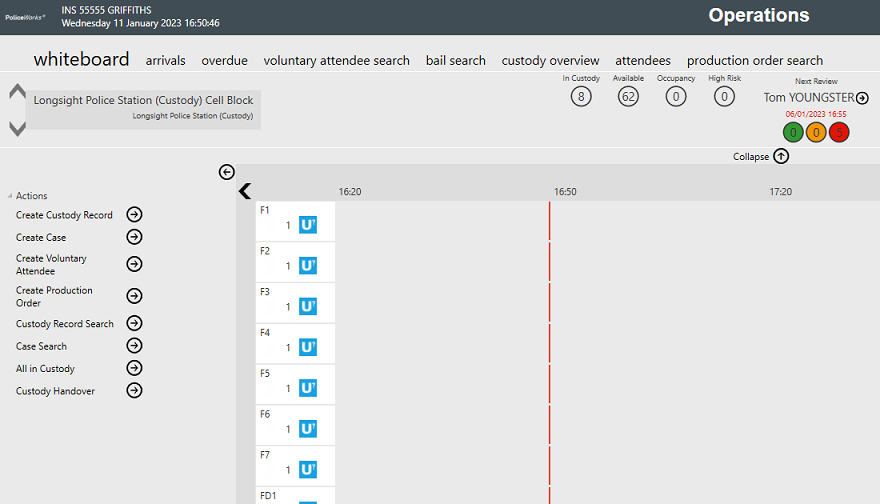

> context menu items

In [ ]:
q = """SELECT ptd.stl_displayTitle FROM stl_viewdisplaytabBase vdt  -- a screen in PW
        WITH(NOLOCK)

        JOIN stl_visualisationBase v
        ON vdt.stl_visualisation = v.stl_visualisationId            -- gives the appearance

        JOIN stl_ViewTabBase vt                                     -- relates to the WPF view
        ON vdt.stl_ViewTab = vt.stl_viewtabId

        JOIN stl_ViewBase vi                                        -- groups them together
        ON vdt.stl_View = vi.stl_viewId

        JOIN stl_cmitovdtBase ctv
        ON vdt.stl_viewdisplaytabId = ctv.stl_ViewDisplayTab        -- context menu items link

        JOIN stl_contextmenuitemBase cmi
        ON ctv.stl_ContextMenuItem = cmi.stl_contextmenuitemId      -- context menu items 

        JOIN stl_cmiprocessdisplayBase cpd
        ON ctv.stl_ContextMenuItem = cpd.stl_ContextMenuItem        -- context menu items display  (this reduces from two to one in case of custody whiteboard - i.e. just actions. Tasks has no ProcessDisplay)

        JOIN stl_processBase p
        ON cpd.stl_Process = p.stl_processId                        -- process

        JOIN stl_processTaskDisplayBase ptd
        ON p.stl_processId = ptd.stl_Process                        -- process display    -- all the items under "Actions" - 9 rows

        JOIN stl_TaskTemplateBase tt
        ON ptd.stl_TaskTemplate = tt.stl_tasktemplateId             -- task template  -- reduced to 8

        --join stl_viewBase vi2
        --ON tt.stl_WizardTargetView =  vi2.stl_viewId              -- none

        --JOIN stl_viewdisplaytabBase vdt2
        --ON tt.stl_targetviewdisplaytab = vdt2.stl_viewdisplaytabId  -- none

        JOIN stl_viewtabBase vt2
        ON tt.stl_targetviewtab = vt2.stl_viewtabId                   -- 8

        --JOIN stl_proceduredefinitionBase pd
        --ON tt.stl_proceduredefinition = pd.stl_proceduredefinitionId  -- leaves the three that are processes (Arrivals Book in, Create Production ORder and Create Voluntary Attendee)

        --where vdt.stl_name = 'custody overview'
        where vdt.stl_name like '%whiteboard%'
        ORDER BY stl_SequenceNo"""

display_data(q)

> main menu items (note that this doesn't quite tie up with the UI above - there must be other parameters controlling visibility)

In [ ]:
q = """SELECT vdt.stl_displaytitle
       FROM stl_ViewBase vi WITH(NOLOCK)

        JOIN stl_viewdisplaytabBase vdt 
        ON vdt.stl_View = vi.stl_viewId

        WHERE vi.stl_DisplayTitle = 'Operations'
        AND vdt.stl_parentVDT IS NULL
        ORDER BY stl_DisplaySequenceNo"""

display_data(q)



![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### dynamic forms

> the form below is dynamically generated from data within CRM

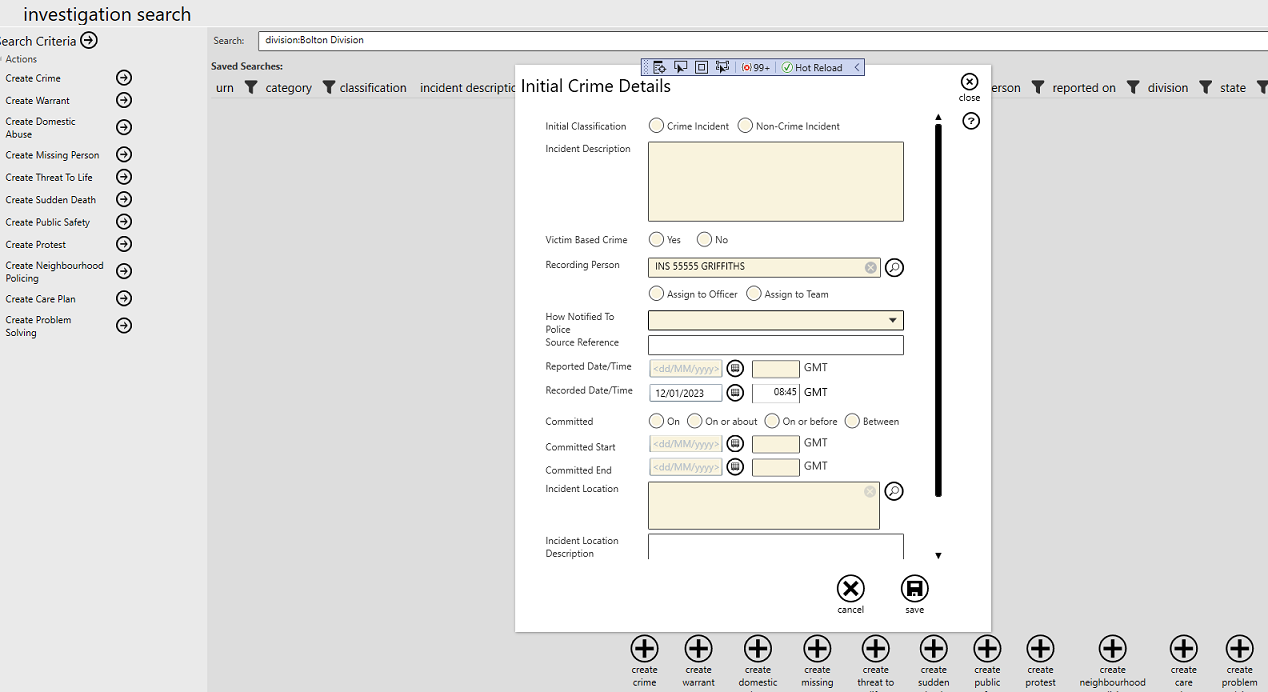


In [ ]:
q = """SELECT   pd.stl_name, 
                pd.stl_description,
                lv.stl_description as [action type],
                sm.[value] as [Workflow Command],
                sd.stl_sectioninitialisation,
                sd.stl_sectionnavigation,
                ad.stl_prompt,
                ad.stl_attributetype,
                ad.stl_validation,
                ad.stl_required,
                ad.stl_hidden,
                ad.stl_attributekey,
                ad.stl_attributetype,
                ad.stl_lookupidentifier


        FROM stl_tasktemplateBase tt WITH (NOLOCK)                        --context menu item

        JOIN stl_viewtabBase vt                                           -- always "ProcedureProcessView" for dynamic forms
        ON vt.stl_viewtabId = tt.stl_targetviewtab

        JOIN stl_proceduredefinitionBase pd
        ON pd.stl_proceduredefinitionId = tt.stl_proceduredefinition      -- 1 to 1 with task template - the top level description of the form

        JOIN [stl_libraryvalueBase] lv
        ON pd.[stl_actiontype] = lv.[stl_libraryvalueId]                  -- action type (that action that gets created once we save the form)

        JOIN StringMapBase sm
        ON  attributeValue = pd.stl_workflowcommand AND sm.ObjectTypeCode = '10033'   -- not sue why there are three - picked one

        JOIN stl_sectiondefinitionBase sd
        ON sd.stl_proceduredefinitionsectionId = pd.stl_proceduredefinitionId     -- only one for this form because there is only one page

        JOIN stl_attributedefinition ad
        ON ad.stl_sectiondefinitionattributesId = sd.stl_sectiondefinitionId AND ad.stl_hidden = 0   -- hidden can change dynamically in response to other attributes

        WHERE tt.stl_name = 'Crime - Initial Details' 

        ORDER BY ad.stl_sectionorder"""

display_data(q)

<div class="alert alert-block alert-info">The attributeKey is how the attribute is referred to in the code embedded in validation, property changed etc (and potentially in .net code)</div>

> attribute type is an option set - for example, for Incident Description the value is "FT" (Free Text), and Initial Classification is "RG" (Radio Group), and Method of Notification is "LV" (Library Value).<br>
"RG" and "FG" have entries in the stl_LibraryValues table


> the stl_querydatasource can contain fetch xml - but none do for this form

> the lookupidentifier for Force is '150005504' but this has no entry in LbraryValues (or anything in stl_querydatasource) ??


In [ ]:
q = "SELECT * FROM StringMapBase where attributeValue = '100000000' AND AttributeName = 'stl_attributetype'"
display_data(q)

In [ ]:
q = """SELECT sm.value, lv.stl_value FROM stl_attributedefinition ad
        JOIN StringMapBase sm ON sm.attributeValue = ad.stl_attributeType AND AttributeName = 'stl_attributetype' 
        JOIN stl_libraryValueBase lv ON lv.stl_identifier = ad.stl_lookupidentifier
        WHERE ad.stl_name = 'CreateCrime - InitialDetails - Initial Classification'"""

display_data(q)

In [ ]:
q = """SELECT sm.value, lv.stl_description FROM stl_attributedefinition ad 
            JOIN StringMapBase sm ON sm.attributeValue = ad.stl_attributeType AND AttributeName = 'stl_attributetype' 
            JOIN stl_libraryValueBase lv ON lv.stl_identifier = ad.stl_lookupidentifier
            WHERE ad.stl_name like 'CreateCrime - InitialDetails - %notif%' and lv.statecode = 0"""
display_data(q)

> example of validation - for Reported Date/Time

In [ ]:
q = """SELECT ad.stl_validation, ad.stl_validationmessage FROM stl_attributedefinition ad 
        WHERE ad.stl_name like 'CreateCrime - InitialDetails - %reported%'"""
display_data(q, max_column_width=150)


> When the dynamic form is part of display tab (as opposed to a modal dialog) - see below - then the view display tab points to the section definition

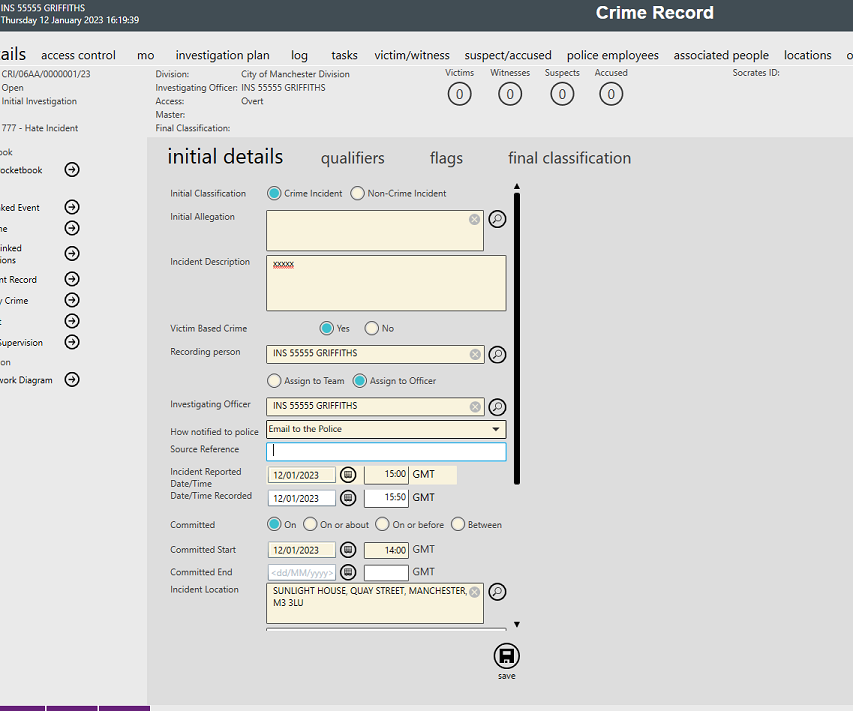

In [ ]:
q = """SELECT v.stl_displaytitle as [view], vdt.stl_displaytitle as tab, vt.stl_ViewTabName as [view tab], vdt2.stl_displaytitle as [sub tab], 
        sd.stl_name as [section definition]
  
      FROM  stl_viewBase v                                                    -- 'Crime Record'

      JOIN stl_viewDisplaytabBase vdt ON v.stl_viewId = vdt.stl_View          -- 'Details'  

      JOIN stl_ViewTabBase vt ON vt.stl_viewtabId = vdt.stl_ViewTab           -- 'Investigation Details View'

      JOIN stl_viewDisplaytabBase vdt2 ON vdt2.stl_parentVDT = vdt.stl_viewdisplaytabId -- 'Initial details'

  JOIN stl_sectiondefinitionBase sd ON sd.stl_sectiondefinitionId = vdt2.stl_SectionDefinitionId
  WHERE v.stl_DisplayTitle = 'Crime Record'  AND vdt2.stl_DisplayTitle = 'initial details'"""

display_data(q)

>Every attribute that is filled in will generate an attribute response

<div class="alert alert-block alert-info">this doesn't seem borne out by the evidence (see below)</div>
        
>These can be used to create data classifications in some cases

>Also one action automatically created and linked to the procedure definition

>Also automatically created is a target parameter which contains the data for the workflow that is triggered

>Rule sets? The Rule Set library soln (.net) picks up the workflow command from the target parameter (I think)

>A rule set has a set of rules - each one has preconditions and what to do if it fires and potentialy what to do if it doen't fire


In [ ]:
q = """ SELECT * FROM stl_attributeresponseBase ar
        JOIN stl_attributedefinitionBase ad  ON ad.stl_attributedefinitionId = ar.stl_attributedefinition
        WHERE ad.stl_name like 'CreateCrime - InitialDetails%'"""

display_data(q)


## The main entities for dynamic forms
<br>

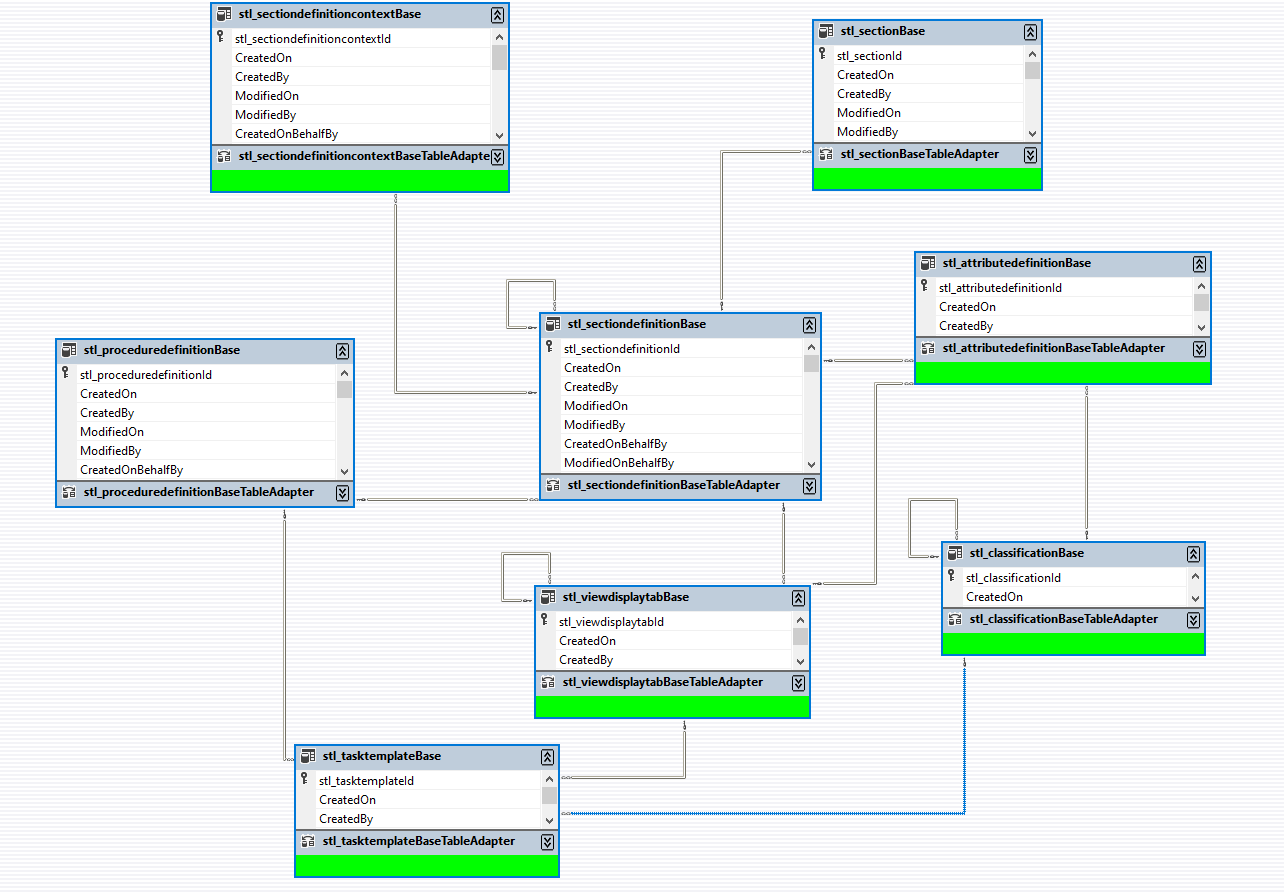


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)